# **1. Install packages**

In [1]:
%%capture
!pip install torchinfo

# **2. Import libraries**

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")

# **3. Load data and EDA**

In [3]:
# Total Images
IMAGE_PATH = Path("D:\\final_year\\cv\\mini_project\\archive\\files")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 87


In [4]:
# number of images per class.
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    print(f"* {c}: {len(total_images_class)} images")

****************************************
           Total Classes = 3
****************************************
* acne: 30 images
* bags: 27 images
* redness: 30 images


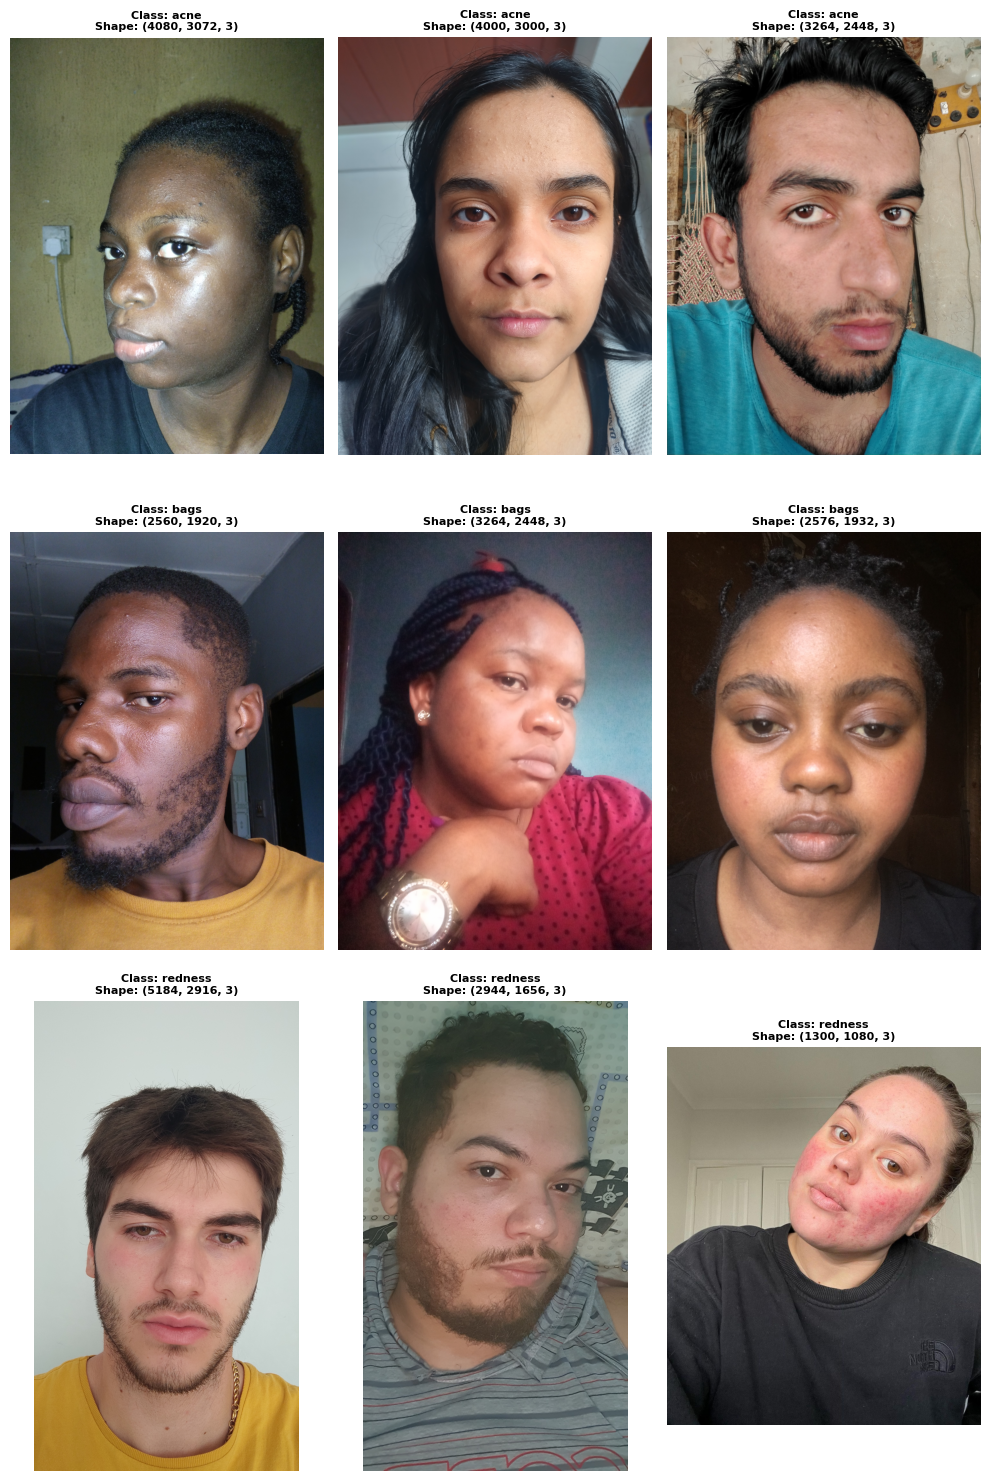

In [5]:
# We view some images for each class.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,15))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis("off")
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize = 8, fontweight = "bold", color = "black")
        
    p += 1
    
fig.tight_layout()
fig.show()

# **4. Preprocessing**

Let's create a dataframe with two columns:

- the first **path** call will store the paths of the images.
- the second call **label** that will contain the labels of each image.

In [6]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.parent.stem
    
df_path_and_label = pd.DataFrame({'path':images_path, 
                                  'label':labels})
df_path_and_label.head()

,path,label
0,D:\final_year\cv\mini_project\archive\files\ac...,acne
1,D:\final_year\cv\mini_project\archive\files\ac...,acne
2,D:\final_year\cv\mini_project\archive\files\ac...,acne
3,D:\final_year\cv\mini_project\archive\files\ac...,acne
4,D:\final_year\cv\mini_project\archive\files\ac...,acne


Now we have to divide our dataframe into 3 parts:

- **train = 70%**
- **valid = 15%**
- **test = 15%**

In [7]:
SEED = 123

df_train, df_rest = tts(df_path_and_label, 
                        test_size = 0.3, 
                        random_state = SEED, 
                        stratify = df_path_and_label["label"])

df_val, df_test = tts(df_rest, 
                      test_size = 0.5, 
                      random_state = SEED, 
                      stratify = df_rest["label"])

In [8]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'acne': 0, 'bags': 1, 'redness': 2}

In [9]:
# Now we define the transformations that we are going to apply.
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Now we are going to create the **Dataset's** and **DataLoader's**.

Let's start with the **Dataset's**.

In [10]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms, label_map:dict):
        self.df = df
        self.transforms = transforms
        self.label_map = label_map
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]
        
        return image,label

In [11]:
train_dataset = CustomDataset(df_train, auto_transforms, label_map)
valid_dataset = CustomDataset(df_val, auto_transforms, label_map)

**DataLoader's**

In [12]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = 0)
valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = 0)

In [13]:
# Let's visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

# **5. Model**

In [14]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [15]:
# We define the model to use with the pre-trained weights.
model = vit_b_16(weights = weights)

In [16]:
# Let's visualize the architecture of the model.
summary(model = model, 
        input_size = [1, 3, 224, 224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         True
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]   [1, 1

We are going to **freeze the parameters of the conv_proj and encoder layers**.

In [17]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [18]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [19]:
# Let's see if the parameters were frozen.
summary(model = model, 
        input_size = [1,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

Great!!, the parameters were frozen.

Let's visualize the last layer which we will modify the number of **out_features**, in this case it is the **number of classes we have**.

In [20]:
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, 
                                                            out_features = output_shape))]))

In [21]:
# One last time let's take a look if the last layer was modified.
summary(model = model, 
        input_size = [1,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

Let's define the **loss function** and the **optimizer**.

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

We are going to define 3 functions for training and one to store the best model:

- **train_step**
- **save_checkpoint**
- **valid_step**
- **train**

In [23]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()


        
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(), 
                                         y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)
    
    return train_loss, train_accuracy

In [24]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {"filename":filename, 
             "model":model.state_dict(), 
             "loss":loss, 
             "epoch":epoch, 
             "optimizer":optimizer.state_dict(), 
             "metric":metric}
    
    torch.save(state, filename)

In [25]:
def valid_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module):
    
    model.eval()
    
    valid_loss = 0.
    valid_accuracy = 0.
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()
            
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)
            
            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
            
    valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)
    
    return valid_loss, valid_accuracy

In [26]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int = 10):
    
    results = {"train_loss":[], 
               "train_accuracy":[], 
               "valid_loss":[], 
               "valid_accuracy":[]}
    
    best_valid_loss = float("inf")
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        valid_loss, valid_accuracy = valid_step(model = model, 
                                                dataloader = valid_dataloader, 
                                                loss_fn = loss_fn)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)
            
        print(f"Epoch: {epoch + 1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"Valid Loss: {valid_loss:.4f} | ", 
              f"Valid Accuracy: {valid_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)
        
    return results

In [27]:

!pip install ipywidgets --upgrade
!jupyter labextension install @jupyter-widgets/jupyterlab-manager




(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)


In [28]:
# Training!!!
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      valid_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 2.2013 |  Train Accuracy: 0.4167 |  Valid Loss: 2.5986 |  Valid Accuracy: 0.3077
Epoch: 2 |  Train Loss: 2.5275 |  Train Accuracy: 0.4667 |  Valid Loss: 5.1825 |  Valid Accuracy: 0.3077
Epoch: 3 |  Train Loss: 2.2999 |  Train Accuracy: 0.4833 |  Valid Loss: 1.8176 |  Valid Accuracy: 0.5385
Epoch: 4 |  Train Loss: 1.1989 |  Train Accuracy: 0.6500 |  Valid Loss: 1.7905 |  Valid Accuracy: 0.4615
Epoch: 5 |  Train Loss: 0.5257 |  Train Accuracy: 0.8167 |  Valid Loss: 1.6575 |  Valid Accuracy: 0.6923
Epoch: 6 |  Train Loss: 0.2223 |  Train Accuracy: 0.9000 |  Valid Loss: 1.1217 |  Valid Accuracy: 0.6923
Epoch: 7 |  Train Loss: 0.4226 |  Train Accuracy: 0.8833 |  Valid Loss: 1.4975 |  Valid Accuracy: 0.6923
Epoch: 8 |  Train Loss: 0.1795 |  Train Accuracy: 0.9500 |  Valid Loss: 2.0954 |  Valid Accuracy: 0.6923
Epoch: 9 |  Train Loss: 0.9476 |  Train Accuracy: 0.7667 |  Valid Loss: 3.2246 |  Valid Accuracy: 0.4615
Epoch: 10 |  Train Loss: 0.7649 |  Train Accuracy: 0.78

In [29]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

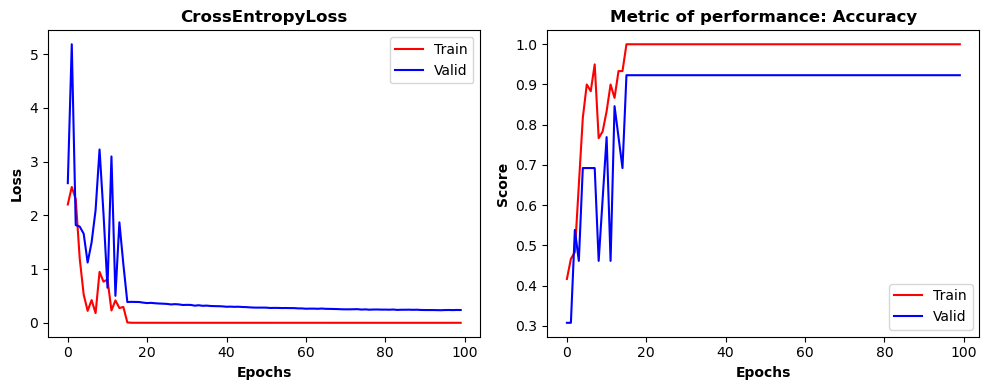

In [30]:
loss_metric_curve_plot(MODEL_RESULTS)

In [31]:
# Let's load the best model.
checkpoint_path = "best_model.pth"
checkpoint = torch.load(checkpoint_path)

In [32]:
# Now let's look at the smallest loss, its metric and when it occurred.
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Best Loss: 0.23390287240121885
Epoch: 95
Best Metric: 0.9230769230769231


Well, now we have to predict the images of the test set.

- **Predictions**

In [33]:
# First of all, we create the Dataset, DataLoader
test_dataset = CustomDataset(df_test, auto_transforms, label_map)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = 0)

In [34]:
# We define the model again with its respective modification.
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768, 
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

  0%|          | 0/14 [00:00<?, ?it/s]

In [35]:
y_pred_test = torch.cat(y_pred_test).numpy()

# **6. Metrics**

- **Accuracy**

In [36]:
print(f'Accuracy = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

Accuracy = 0.8571


- **Confusion Matrix**

In [37]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test)

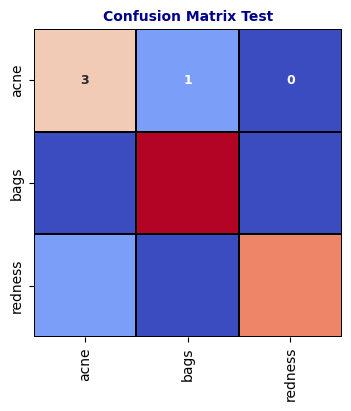

In [38]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test, 
            cmap = 'coolwarm', 
            annot = True, 
            annot_kws = {"fontsize":9, "fontweight":"bold"}, 
            linewidths = 1.2, 
            linecolor = "black", 
            square = True, 
            xticklabels = classes, 
            yticklabels = classes, 
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()

In [39]:
pip install ipywidgets pillow torch


In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

In [ ]:
# Load the model with modifications
loaded_model = vit_b_16()  # Ensure vit_b_16 is properly imported or defined

# Modify the head for your specific classes
loaded_model.heads = nn.Sequential(OrderedDict([
    ('head', nn.Linear(in_features=768, out_features=output_shape))
]))

In [ ]:
# Load model weights
loaded_model.load_state_dict(checkpoint["model"])

# Move model to the appropriate device
loaded_model.to(device)
loaded_model.eval()

# Function to suggest treatment based on predicted class
def suggest_treatment(predicted_class):
    treatment_suggestions = {
        0: "Treatment A for Class 0",
        1: "Treatment B for Class 1",
        2: "Treatment C for Class 2",
        # Add more treatments for additional classes as needed
    }
    return treatment_suggestions.get(predicted_class.item(), "No treatment suggestion available.")

# Function to preprocess the image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size of the model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')  # Load image
    image = preprocess(image)  # Apply preprocessing
    return image.unsqueeze(0)  # Add batch dimension

# Function for predicting images and suggesting treatment
def predict_and_suggest(image_paths):
    predictions = []
    for image_path in image_paths:
        # Preprocess the image
        image = preprocess_image(image_path).to(device)
        
        # Make prediction
        with torch.inference_mode():
            y_pred_logit = loaded_model(image)
            y_pred_prob = torch.softmax(y_pred_logit, dim=1)
            y_pred_class = torch.argmax(y_pred_prob, dim=1)
            predictions.append(y_pred_class.item())

            # Suggest treatment
            treatment = suggest_treatment(y_pred_class)
            print(f"Predicted Class: {y_pred_class.item()}, Suggested Treatment: {treatment}")
    
    return predictions

# Example usage with test dataloader
y_pred_test = []
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim=1)
        y_pred_class = torch.argmax(y_pred_prob, dim=1)
        y_pred_test.append(y_pred_class.detach().cpu())

# Example image prediction and treatment suggestion
image_paths = ["C:\\Users\\hp\\OneDrive\\Desktop\\front.jpg", "C:\\Users\\hp\\OneDrive\\Desktop\\face.jpg"]  # Replace with your image paths
predictions = predict_and_suggest(image_paths)